# Выборка #9

In [73]:
%run init.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Обзор данных

In [74]:
dataset = Dataset(9)
dataset.summary()

+---------+-----------------------+----------------------+-------------+------------------+
| Выборка | Обучающая, # объектов | Тестовая, # объектов | # признаков | Доля класса 1, % |
+---------+-----------------------+----------------------+-------------+------------------+
|    9    |          1000         |        10000         |     1500    |       18.0       |
+---------+-----------------------+----------------------+-------------+------------------+


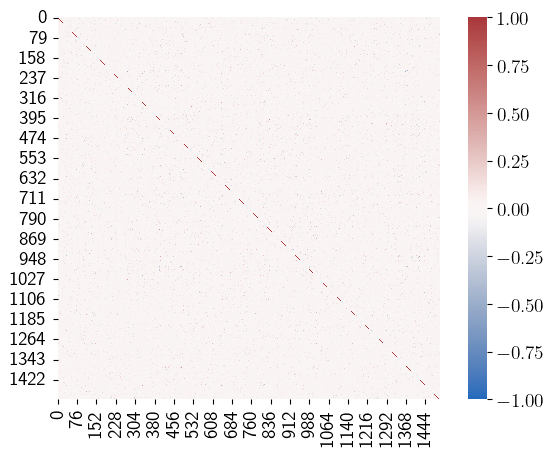

In [3]:
dataset.heatmap()

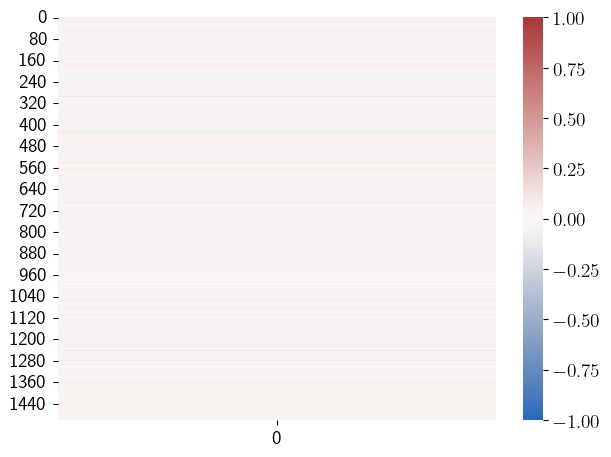

In [4]:
dataset.target_corr(annot=False)

In [5]:
#make_histplot(dataset.df)

### Проверка нормальности признаков

Используем критерий Шапиро-Уилка

In [3]:
pvals = [shapiro(dataset.X1[i])[1] for i in range(dataset.n_features)]

Получим достигаемые уровни значимости для нулевой гипотезы: "Распределение признака является нормальным"

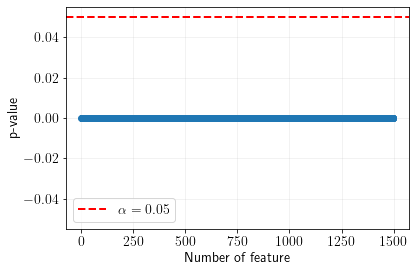

In [87]:
plt.plot(pvals, linestyle='None', marker='o')
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha=0.05$')

plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('p-value')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'./fig/dataset_{dataset.dataset_id}/shapiro.pdf', bbox_inches='tight')
plt.show()

Исключим все объекты со значениями признаков < 0.05-квантиля и больше > 0.95-квантиля

In [75]:
X1_stage1 = dataset.X1[dataset.X1 > dataset.X1.quantile(q=0.05)][dataset.X1 < dataset.X1.quantile(q=0.95)]
X2_stage1 = dataset.X2[dataset.X2 > dataset.X1.quantile(q=0.05)][dataset.X2 < dataset.X1.quantile(q=0.95)]

Заполним все пропущенные значения средними значениями по каждому признаку

In [76]:
X1_stage2 = X1_stage1.fillna(X1_stage1.mean())
X2_stage2 = X2_stage1.fillna(X1_stage1.mean())

Подготовка обработанных датасетов для работы моделей

In [77]:
dataset.X1 = X1_stage2 
dataset.X2 = X2_stage2 

dataset.get_scaled_data()
dataset.get_divergences()

In [56]:
dataset.divergences[dataset.divergences > 0.7].shape[0]

2

Стандартизуем

In [10]:
scaler = StandardScaler()
X1_stage2_scaled = pd.DataFrame(scaler.fit_transform(X1_stage2))
X2_stage2_scaled = pd.DataFrame(scaler.fit_transform(X2_stage2))

In [11]:
dataset.X1 = X1_stage2
dataset.X2 = X2_stage2

dataset.X1_scaled = X1_stage2_scaled
dataset.X2_scaled = X2_stage2_scaled

<Axes: >

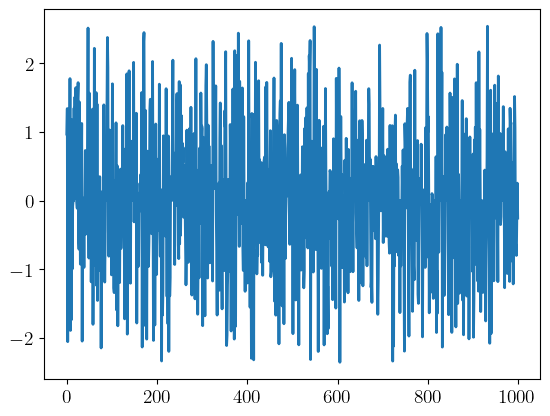

In [12]:
X1_stage2_scaled[0].plot()

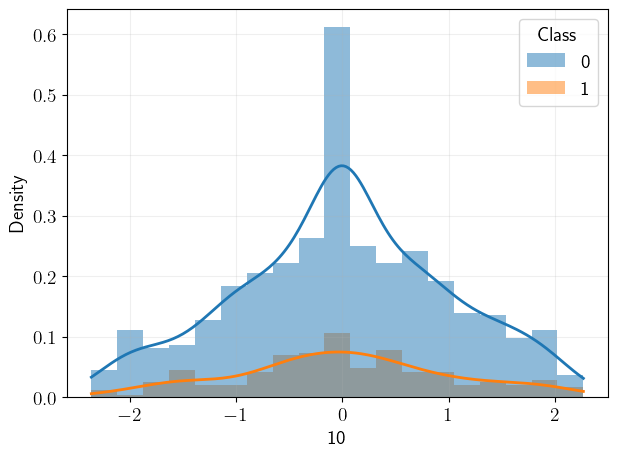

In [31]:
df = pd.concat([X1_stage2_scaled, dataset.y1], axis=1)

sns.histplot(data=df, x=df[10], stat='density', hue='Class', kde=True, edgecolor=None)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Проверим гипотезу для уже отфильтрованных признаков

In [86]:
pvals = [shapiro(X1_stage2_scaled[i])[1] for i in range(dataset.n_features)]

NameError: name 'X1_stage2_scaled' is not defined

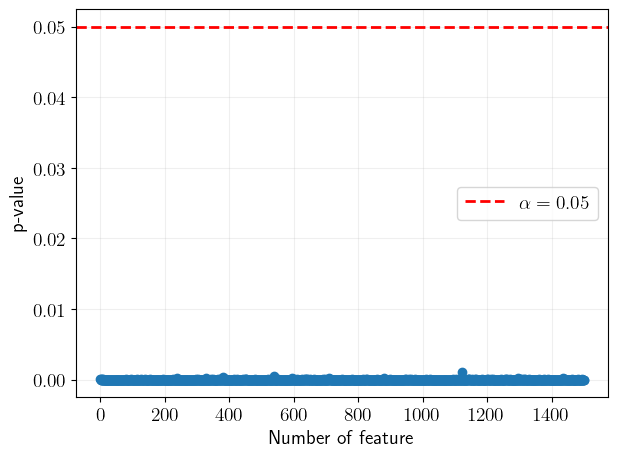

In [33]:
plt.plot(pvals, linestyle='None', marker='o')
plt.axhline(y=0.05, color='r', linestyle='dashed', label=r'$\alpha=0.05$')

plt.legend()
plt.xlabel('Number of feature')
plt.ylabel('p-value')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'./fig/dataset_{dataset.dataset_id}/shapiro.pdf', bbox_inches='tight')
plt.show()

Очень похоже на то, что признаки имеют распределение Лапласа.

In [36]:
loc, scale = laplace.fit(X1_stage2_scaled[0])

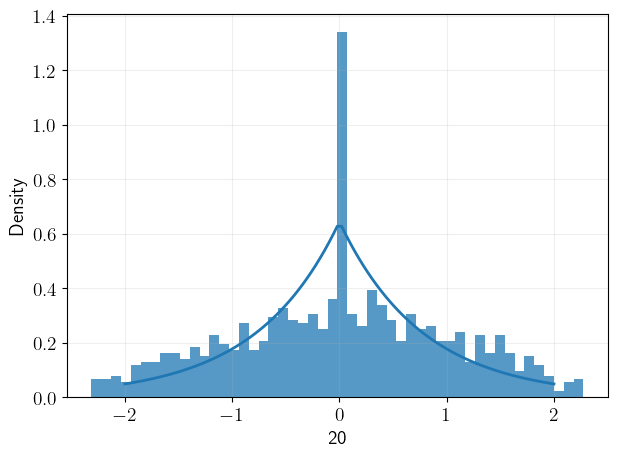

In [43]:
x = np.linspace(-2, 2, 100)
plt.plot(x, laplace.pdf(x, loc=loc, scale=scale))

df = pd.concat([X1_stage2_scaled, dataset.y1], axis=1)
sns.histplot(data=df, x=df[20], bins=50, stat='density', edgecolor=None)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

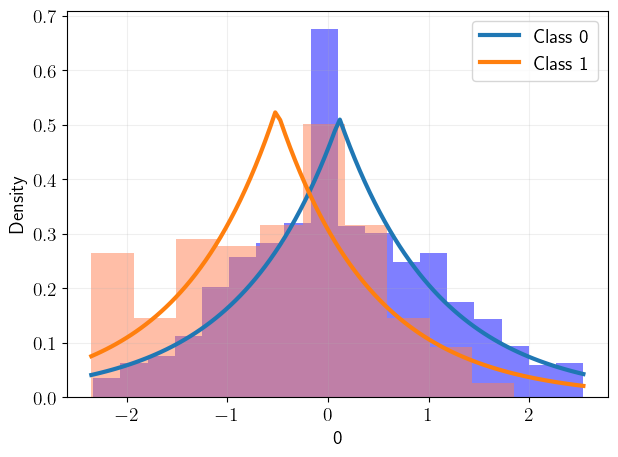

In [44]:
loc_1, scale_1 = norm.fit(X1_stage2_scaled[0][dataset.y1 == 1])
loc_0, scale_0 = norm.fit(X1_stage2_scaled[0][dataset.y1 == 0])

sns.histplot(X1_stage2_scaled[0][dataset.y1 == 0], color='blue', stat='density', edgecolor=None, alpha=0.5)
sns.histplot(X1_stage2_scaled[0][dataset.y1 == 1], color='coral', stat='density', edgecolor=None, alpha=0.5)

grid = np.linspace(min(X1_stage2_scaled[0]), max(X1_stage2_scaled[0]), 100)
plt.plot(grid, laplace.pdf(grid, loc=loc_0, scale=scale_0), linewidth=3, label='Class 0')
plt.plot(grid, laplace.pdf(grid, loc=loc_1, scale=scale_1), linewidth=3, label='Class 1')

plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

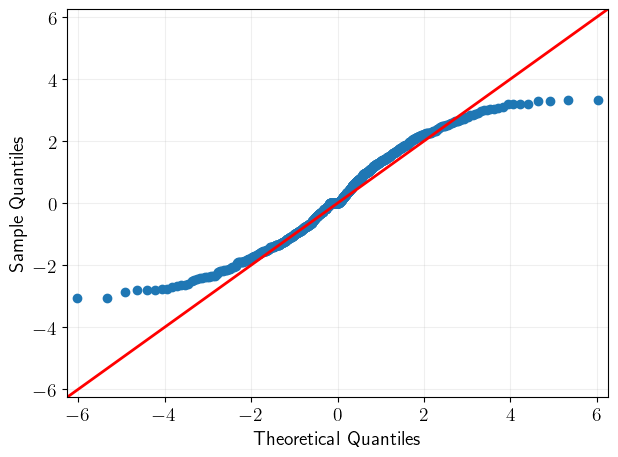

In [45]:
qqplot(data=X1_stage2_scaled[0][dataset.y1 == 0], dist=laplace, fit=True, line='45')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

---

### Logistic Regression

100%|██████████| 99/99 [00:36<00:00,  2.74it/s]


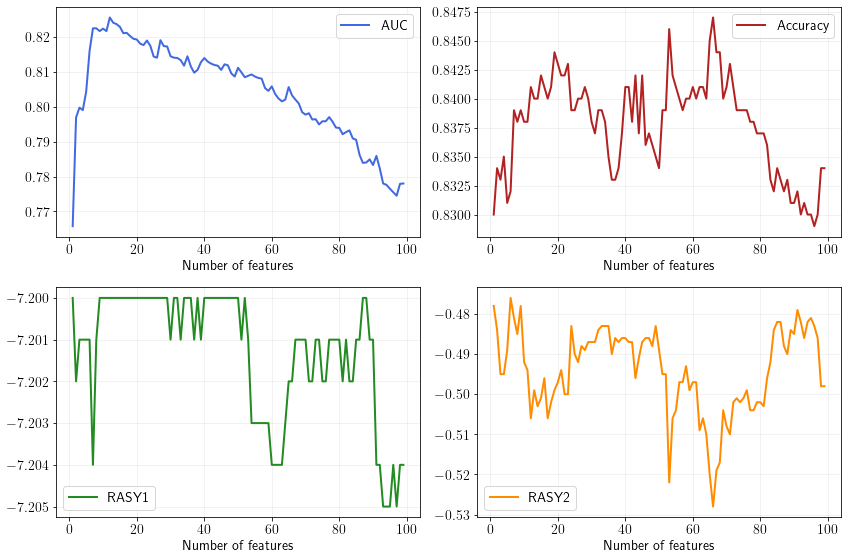

In [78]:
features_cols_lr = dataset.metrics_n_features_dependence(LogisticRegression(), ks = range(1, 100))

100%|██████████| 21/21 [00:36<00:00,  1.75s/it]


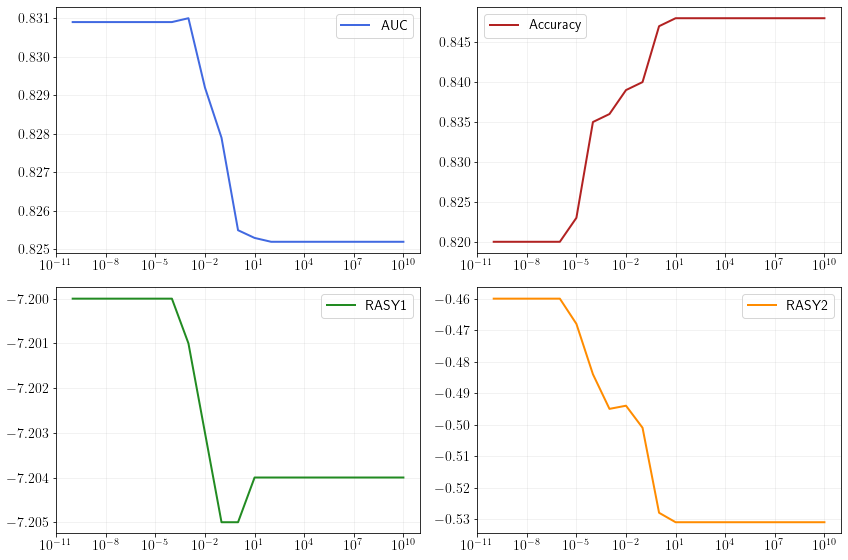

In [79]:
Cs_lr = LogisticRegressionValidate(dataset, features_cols_lr, np.logspace(-10, 10, 21))

### Naive Bayes

100%|██████████| 99/99 [00:20<00:00,  4.92it/s]


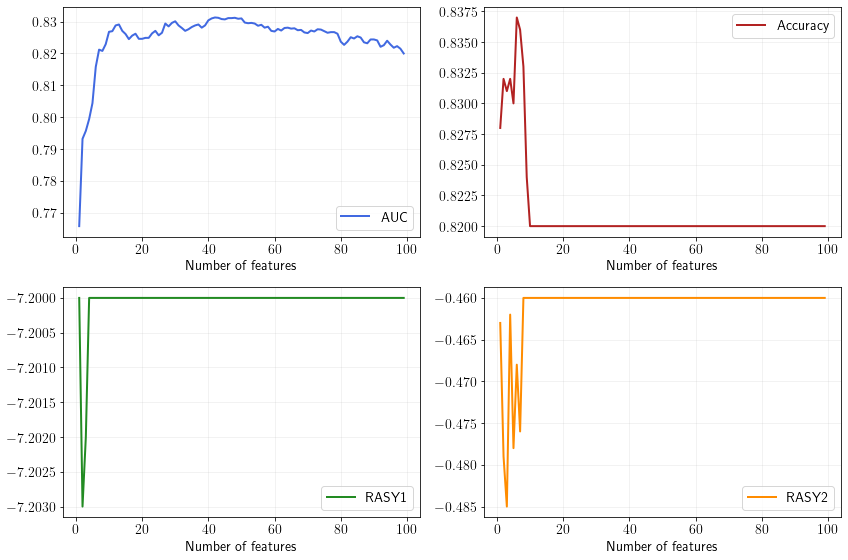

In [59]:
features_cols_gnb = dataset.metrics_n_features_dependence(GaussianNB(), ks = range(1, 100))

Random forest

100%|██████████| 19/19 [00:48<00:00,  2.54s/it]


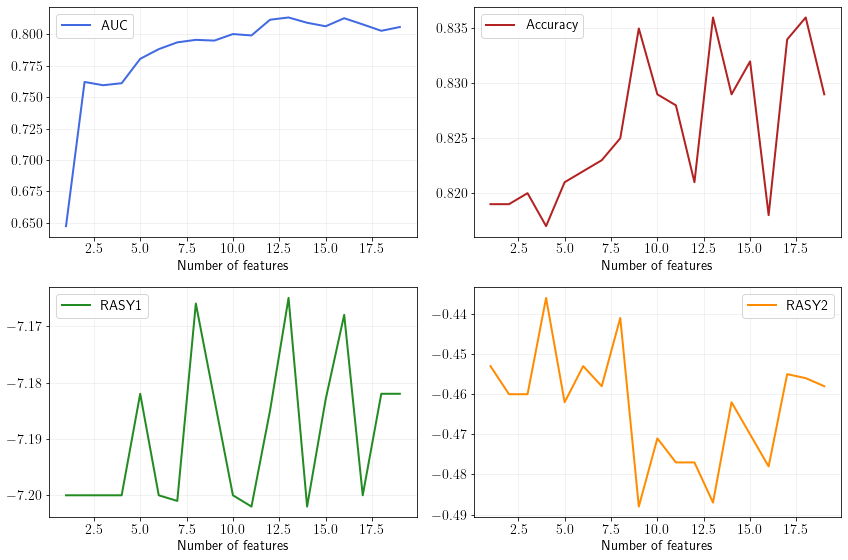

In [72]:
from sklearn.ensemble import RandomForestClassifier

features_cols_rfc = dataset.metrics_n_features_dependence(RandomForestClassifier(class_weight='balanced', n_jobs = -1), ks = range(1, 20))

### Saving aswers 

In [80]:
model_AUC = LogisticRegression(C=Cs_lr['AUC']['C'])
model_Accuracy = LogisticRegression(C=Cs_lr['Accuracy']['C'])
model_RASY1 = LogisticRegression(C=Cs_lr['RASY1']['C'])
model_RASY2 = LogisticRegression(C=Cs_lr['RASY2']['C'])
models = [model_AUC, model_Accuracy, model_RASY1, model_RASY2]

In [81]:
features_AUC, cols_AUC = features_cols_lr['AUC']['features'], features_cols_lr['AUC']['cols']
features_Accuracy, cols_Accuracy = features_cols_lr['Accuracy']['features'], features_cols_lr['Accuracy']['cols']
features_RASY1, cols_RASY1 = features_cols_lr['RASY1']['features'], features_cols_lr['RASY1']['cols']
features_RASY2, cols_RASY2 = features_cols_lr['RASY2']['features'], features_cols_lr['RASY2']['cols']
features_list = [features_AUC, features_Accuracy, features_RASY1, features_RASY2]
cols_list = [cols_AUC, cols_Accuracy, cols_RASY1, cols_RASY2]

In [82]:
t_Accuracy = features_cols_lr['Accuracy']['t']
t_RASY1 = features_cols_lr['RASY1']['t']
t_RASY2 = features_cols_lr['RASY2']['t']
thresholds_list = [t_Accuracy, t_RASY1, t_RASY2]

In [83]:
dataset.save_ans(models, features_list, cols_list, thresholds_list)

In [92]:
Cs_lr

{'AUC': {'C': 0.001},
 'Accuracy': {'t': 0.686868686868687, 'C': 10.0},
 'RASY1': {'t': 0.9191919191919192, 'C': 0.1},
 'RASY2': {'t': 0.686868686868687, 'C': 10.0}}

In [91]:
cols_list[3].shape

(66,)

In [85]:
thresholds_list

[0.6666666666666667, 0.9595959595959597, 0.6767676767676768]